In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

import pickle
import joblib
import json


# Read the CSV file and preprocess the data
df = pd.read_csv('/stock_data_df.csv')



TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [ ]:
# Split the data into training and testing sets
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]



In [ ]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Close', 'volume', 'Returns']])
test_scaled = scaler.transform(test_data[['Close', 'volume', 'Returns']])

 # Save the scaling parameters to a file
scaling_parameters = {"min": scaler.data_min_.tolist(), "max": scaler.data_max_.tolist()}
with open("scaling_parameters.json", "w") as scaling_parameter_file:
    json.dump(scaling_parameters, scaling_parameter_file)


In [ ]:
# Create sequences for LSTM input
def create_lstm_sequences(data, timesteps):
    X_lstm = []
    y_lstm = []
    for i in range(len(data) - timesteps):
        X_lstm.append(data[i:i+timesteps])
        y_lstm.append(data[i+timesteps, -1])
    return np.array(X_lstm), np.array(y_lstm)

timesteps = 10  # Number of past time steps to consider for each sequence
X_train, y_train = create_lstm_sequences(train_scaled, timesteps)
X_test, y_test = create_lstm_sequences(test_scaled, timesteps)



In [ ]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(timesteps, X_train.shape[2])))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
#Train the model
model.fit(X_train, y_train, epochs=60, batch_size=32)



Epoch 1/60
338/338 [==============================] - 7s 11ms/step - loss: 0.0024
Epoch 2/60
338/338 [==============================] - 3s 10ms/step - loss: 0.0017
Epoch 3/60
338/338 [==============================] - 4s 12ms/step - loss: 0.0016
Epoch 4/60
338/338 [==============================] - 5s 14ms/step - loss: 0.0016
Epoch 5/60
338/338 [==============================] - 3s 10ms/step - loss: 0.0016
Epoch 6/60
338/338 [==============================] - 3s 10ms/step - loss: 0.0016
Epoch 7/60
338/338 [==============================] - 4s 13ms/step - loss: 0.0015
Epoch 8/60
338/338 [==============================] - 4s 13ms/step - loss: 0.0015
Epoch 9/60
338/338 [==============================] - 4s 11ms/step - loss: 0.0015
Epoch 10/60
338/338 [==============================] - 3s 10ms/step - loss: 0.0015
Epoch 11/60
338/338 [==============================] - 5s 14ms/step - loss: 0.0015
Epoch 12/60
338/338 [==============================] - 4s 12ms/step - loss: 0.0015
Epoch 13/60
3

In [ ]:
#make predictions

y_pred = model.predict(X_test)

85/85 [==============================] - 1s 5ms/step


In [ ]:
#get mean squared Error
mse = np.mean((y_pred - y_test)**2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.006272634210758138


In [ ]:
#Rename Y_pred
predicted_returns_scaled = model.predict(X_test)


85/85 [==============================] - 1s 6ms/step


In [ ]:
# Inverse scale the predicted values
unscaled_returns = scaler.inverse_transform(np.hstack((X_test[:, -1, :-1], predicted_returns_scaled)))

In [ ]:
# Add the predicted returns to the test_data DataFrame
test_data = test_data.iloc[:2691]
#test_data.loc[:, 'Predicted_Returns'] = unscaled_returns[:, -1]
test_data['Predicted_Returns'] = unscaled_returns[:, -1]

test_data

<ipython-input-18-4e5453123667>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_Returns'] = unscaled_returns[:, -1]


,Date,ticker,Close,volume,Returns,Predicted_Returns
10800,7/26/2021,DAL,41.669998,10014900.0,0.799223,0.572953
10801,7/27/2017,UAL,68.089996,7925700.0,0.634029,-0.193763
10802,7/27/2017,HLT,60.973877,2882500.0,-0.104510,1.530940
10803,7/27/2017,CAKE,43.219540,1591800.0,-0.291179,0.245587
10804,7/27/2017,CCL,60.297634,3817700.0,0.395148,-0.487304
...,...,...,...,...,...,...
13486,9/9/2020,MAR,100.835289,2630100.0,1.798648,-0.510666
13487,9/9/2020,CAKE,29.831955,1453500.0,-0.704152,-0.456846
13488,9/9/2020,AMZN,163.430496,103774000.0,4.478370,3.071229
13489,9/9/2020,CCL,17.660000,36217900.0,-0.891942,0.908397


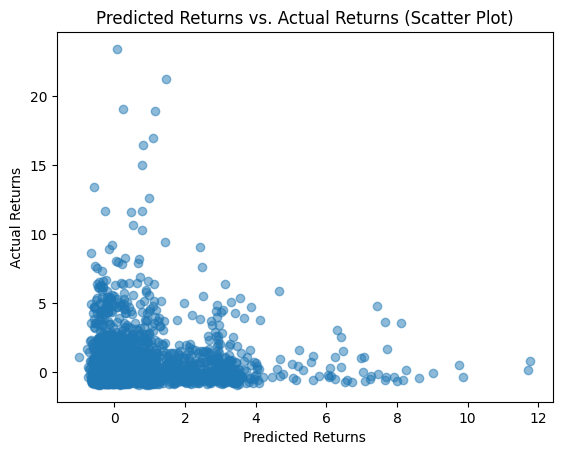

In [ ]:
import matplotlib.pyplot as plt


# Extract the predicted returns and actual returns from the DataFrame
predicted_returns = test_data["Predicted_Returns"]
actual_returns = test_data["Returns"]

# Create a scatter plot
plt.scatter(predicted_returns, actual_returns, alpha=0.5)

# Set labels and title
plt.xlabel("Predicted Returns")
plt.ylabel("Actual Returns")
plt.title("Predicted Returns vs. Actual Returns (Scatter Plot)")

# Show the plot
plt.show()

In [ ]:
# using model to predict returns using new data
# read data from csv
new_data_df = pd.read_csv('/2022-23.csv')

In [ ]:
# Rename the 'price' column to 'Close'
new_data_df = new_data_df.rename(columns={"price": "Close"})

# Drop rows with missing values (NaNs)
new_data_df = new_data_df.dropna()

# Sort the DataFrame by 'Date' (if it's not already sorted)
new_data_df = new_data_df.sort_values('Date')

# Calculate returns using the 'shift' function
new_data_df['PrevClose'] = new_data_df['Close'].shift(1)
new_data_df['Returns'] = (new_data_df['Close'] - new_data_df['PrevClose']) / new_data_df['PrevClose']

# Drop the temporary 'PrevClose' column
new_data_df = new_data_df.drop('PrevClose', axis=1)
new_data_df = new_data_df.dropna()
new_data_df

,Unnamed: 0,Date,ticker,Close,volume,Returns
3191,3191,1/10/2022,AMZN,161.485992,87798000.0,3.355245
359,359,1/10/2022,UAL,46.580002,9204500.0,-0.711554
5,5,1/10/2022,HLT,147.796417,2652300.0,2.172959
3545,3545,1/10/2022,WMT,141.254273,7577200.0,-0.044265
1421,1421,1/10/2022,MAR,160.183914,2228400.0,0.134011
...,...,...,...,...,...,...
1234,1234,9/9/2022,DAL,32.660000,10958900.0,-0.002228
3004,3004,9/9/2022,RUTH,18.221096,274858.0,-0.442097
2650,2650,9/9/2022,WH,67.461578,678600.0,2.702389
1588,1588,9/9/2022,MAR,161.076309,1392400.0,1.387675


In [ ]:
#Scale the data

scaler = MinMaxScaler()
columns_to_scale = ['Close', 'volume', 'Returns']
new_data_scaled = scaler.fit_transform(new_data_df[columns_to_scale])

In [ ]:
# Define the number of past time steps to consider for each sequence
timesteps = 10

# Create sequences with timesteps
X_new_sequences = []
for i in range(len(new_data_scaled) - timesteps + 1):
    X_new_sequences.append(new_data_scaled[i:i + timesteps])

# Convert X_new_sequences to a numpy array
X_new_with_sequences = np.array(X_new_sequences)

In [ ]:
# declare variable for actual values
y_actual = new_data_df["Returns"]

# Make predictions using trained LSTM model
predicted_returns_scaled = model.predict(X_new_with_sequences)

# Reshape y_actual to match the shape of predicted_returns_scaled
y_reshaped = y_actual[-len(predicted_returns_scaled):].values.reshape(-1, 1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((predicted_returns_scaled - y_reshaped) ** 2)
print(f"Mean Squared Error: {mse}")

122/122 [==============================] - 1s 8ms/step
Mean Squared Error: 8.349912344357886


In [ ]:

# Reshape predicted_returns_scaled to have shape (3884, 1)
predicted_returns_reshaped = predicted_returns_scaled.reshape(-1, 1)

# Remove the first timesteps rows from new_data_scaled to match the length of predicted_returns_scaled
new_data_scaled_trimmed = new_data_scaled[timesteps-1:]

# Create a new scaler object for the predicted returns with feature_range=(0, 1)
returns_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the returns_scaler on the predicted returns
returns_scaler.fit(predicted_returns_reshaped)

# Transform the predicted returns with the fitted scaler
predicted_returns_unscaled = returns_scaler.inverse_transform(predicted_returns_reshaped)

# Horizontally stack predicted_returns_unscaled with new_data_scaled_trimmed
combined_data = np.hstack((new_data_scaled_trimmed, predicted_returns_unscaled))

column_names = ['Close', 'Volume', 'Returns', 'Predicted_Returns']

# Convert the combined_data array to a DataFrame
combined_df = pd.DataFrame(combined_data, columns=column_names)
combined_df


,Close,Volume,Returns,Predicted_Returns
0,0.069897,0.000788,0.021936,0.049104
1,0.173595,0.003059,0.101059,0.023334
2,0.018159,0.142623,0.010759,0.069969
3,0.675796,0.003148,0.693151,0.006034
4,0.459421,0.248154,0.033716,0.008184
...,...,...,...,...
3879,0.144611,0.039750,0.049465,0.026890
3880,0.065158,0.000548,0.026536,0.048583
3881,0.336114,0.002029,0.190448,0.011929
3882,0.851249,0.004648,0.121916,0.002827


In [ ]:
# Drop extra rows from the DataFrame to match the length of 'combined_data'
new_data_df = new_data_df.iloc[:len(combined_data)]

# Add the unscaled predicted returns as a new column 'Predicted_Returns' to the DataFrame
new_data_df['Predicted_Returns'] = combined_data[:, -1]

new_data_df

<ipython-input-27-38cfbe3b10bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_df['Predicted_Returns'] = combined_data[:, -1]


,Unnamed: 0,Date,ticker,Close,volume,Returns,Predicted_Returns
3191,3191,1/10/2022,AMZN,161.485992,87798000.0,3.355245,0.049104
359,359,1/10/2022,UAL,46.580002,9204500.0,-0.711554,0.023334
5,5,1/10/2022,HLT,147.796417,2652300.0,2.172959,0.069969
3545,3545,1/10/2022,WMT,141.254273,7577200.0,-0.044265,0.006034
1421,1421,1/10/2022,MAR,160.183914,2228400.0,0.134011,0.008184
...,...,...,...,...,...,...,...
2295,2295,9/8/2022,RCL,45.160000,6233700.0,-0.652134,0.026890
879,879,9/8/2022,CCL,10.080000,41765200.0,-0.776794,0.048583
1587,1587,9/8/2022,MAR,158.139710,1690800.0,14.688463,0.011929
526,526,9/9/2022,UAL,39.259998,7405000.0,-0.751739,0.002827


In [ ]:
joblib.dump(model, 'LSTM_model.pkl')

['LSTM_model.pkl']

In [ ]:
# declare variable for actual values
y_actual = new_data_df["Returns"]

# Make predictions using trained LSTM model
predicted_returns_scaled = model.predict(X_new_with_sequences)

# Reshape y_actual to match the shape of predicted_returns_scaled
y_reshaped = y_actual[-len(predicted_returns_scaled):].values.reshape(-1, 1)

# Calculate Mean Squared Error (MSE)
mse = np.mean((predicted_returns_unscaled - y_reshaped) ** 2)
print(f"Mean Squared Error: {mse}")

122/122 [==============================] - 1s 4ms/step
Mean Squared Error: 8.250567657722165


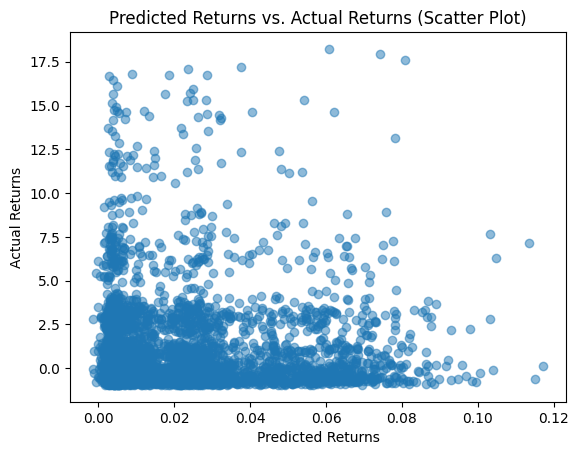

In [ ]:
import matplotlib.pyplot as plt


# Extract the predicted returns and actual returns from the DataFrame
predicted_returns = new_data_df["Predicted_Returns"]
actual_returns = new_data_df["Returns"]

# Create a scatter plot
plt.scatter(predicted_returns, actual_returns, alpha=0.5)

# Set labels and title
plt.xlabel("Predicted Returns")
plt.ylabel("Actual Returns")
plt.title("Predicted Returns vs. Actual Returns (Scatter Plot)")

# Show the plot
plt.show()
